In [15]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


# Project 3: Problem 3 (p33)

## Physics Constants

In [16]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Wavelength: 0.9993 m
K0^2: 39.5331 1/m


## 3-noded Linear Triangular Elements, $P_1$

In [17]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 301, 'name': 'PML_a','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 302, 'name': 'PML_b','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 303, 'name': 'PML_c','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 304, 'name': 'PML_d','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 401, 'name': 'PML_I','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 402, 'name': 'PML_II','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 403, 'name': 'PML_III','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 404, 'name': 'PML_IV','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Criar geometria coaxial
GEOMETRY = {'h': WAVELENGTH/25, 'L': WAVELENGTH*1, 'ra': WAVELENGTH*0.5, 'x0': 1.0*WAVELENGTH}
mesh_data = ps.create_p4_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, GEOMETRY, view_mesh=False)

# Parâmetros da PML
PML_DESIGN = {
    'x0': GEOMETRY['x0'],   # Interface inicial do PML
    'n': 2.0,               # Ordem polinomial do PML
    'R': 1E-4,              # Coeficiente de reflexão
}

# Aplicar a física do problema
mesh_data = ps.apply_pml_physics(FINITE_ELEMENT, PML_DESIGN, mesh_data)

Malha salva em pre_processing/mesh/rectangular_pml_domain_Triangle1.msh
Model rectangular_pml (2D)
Info     : 51 geometric entities
Info     : 10 Physical Groups
Info     : 11452 nodes in total
Info     : 22425 2 elements in total


## Figure 1: Meshed $\Omega_c$ domain 

In [18]:
INFO_GRAPH = {'cell': False, 'nodes': False, 'edges': False, 'edges_numb': False}
graph.plot_mesh(FINITE_ELEMENT, INFO_GRAPH, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


## FEM Solution

In [19]:
# Montagem das matrizes globais
Sg, Mg, bg = ps.pml_global_matrices(FINITE_ELEMENT, mesh_data)

# Aplicar condições de contorno de Dirichlet sobre o espalhador
Sg, Mg, bg = ps.apply_simple_bcs(Sg, Mg, bg, mesh_data)

# Solução do problema matricial
uh = spsolve((Sg + Mg).tocsr(), bg.toarray())

# Dicionário com os resultados numéricos
ezh = {key+1: value for key, value in enumerate(uh)}

## Figure 2: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


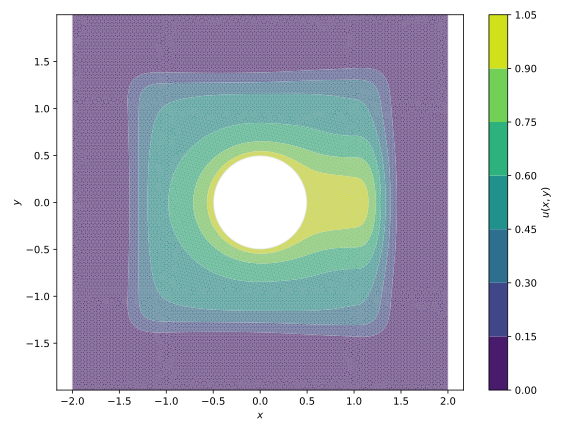

In [20]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, ezh, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1_EntireDomain.svg"))

## Figure 3: Meshed Physical Domain, $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_physical_domain_Triangle1_EntireDomain.svg


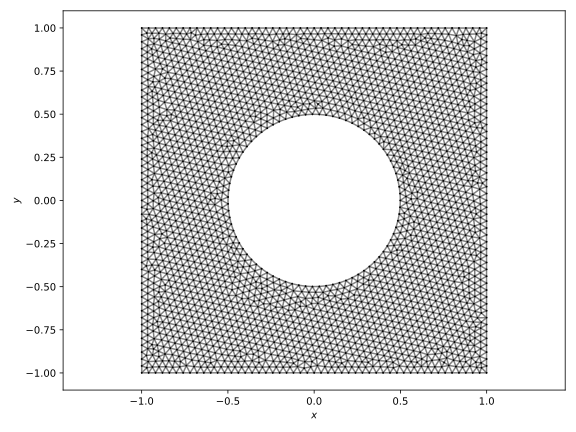

In [21]:
physical_mesh_data = ps.get_physical_mesh_data(mesh_data)
ps.plot_physical_mesh(FINITE_ELEMENT, mesh_data, physical_mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 4: $|E_{zh}^s|$ Analytical Solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg


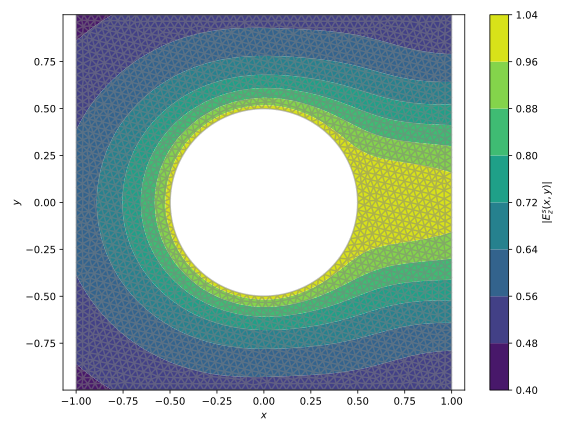

In [22]:
ez_phy = ps.solution_at_physical_domain(FINITE_ELEMENT, GEOMETRY, physical_mesh_data)
display(SVG(filename="pos_processing/pictures/analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 5: $|E_{zh}^s|$ Numerical solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_at_physical_domain_Triangle1_EntireDomain.svg


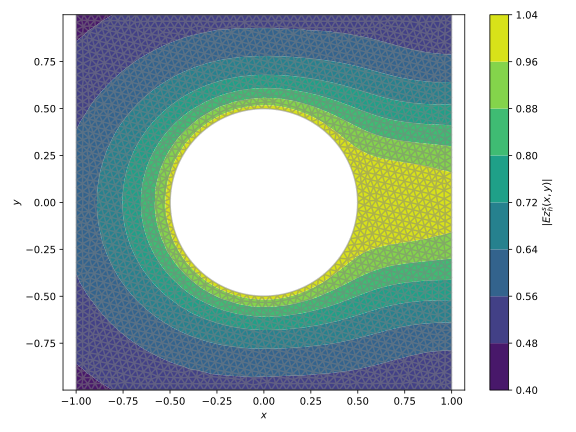

In [23]:
ezh_phy = ps.fem_solution_at_physical_domain(FINITE_ELEMENT, mesh_data, physical_mesh_data, ezh)
display(SVG(filename="pos_processing/pictures/fem_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 6: $|E_{zh}|$ Numerical solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_at_physical_domain_Triangle1_EntireDomain.svg


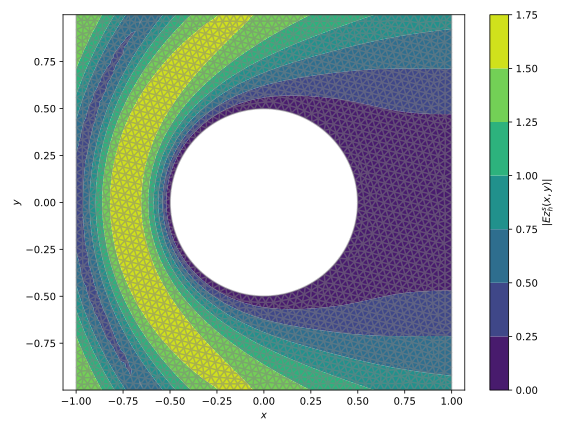

In [24]:
uth_phy = {key: np.exp(-1j * K0 * node['xg'][0]) + ezh_phy[key]
            for key, node in physical_mesh_data['nodes'].items()}

ps.fem_solution_at_physical_domain(FINITE_ELEMENT, mesh_data, physical_mesh_data, uth_phy)
display(SVG(filename="pos_processing/pictures/fem_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.